# Import settings

In [1]:
import kagglehub
import pandas as pd

C:\Users\leeun\PycharmProjects\WeatherProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


download datas from kagglehub.

In [2]:
path = kagglehub.dataset_download("muthuj7/weather-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\leeun\.cache\kagglehub\datasets\muthuj7\weather-dataset\versions\1


Put your printed file result to see if the file loaded.

In [3]:
file_path = r"C:/Users/leeun/.cache/kagglehub/datasets/muthuj7/weather-dataset/versions/1/weatherHistory.csv"

df = pd.read_csv(file_path)
print(df.head())

                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13  

Decision Trees (and most ML algorithms) work best with numerical data (typically floats or integers).
We need to adjust string values to any float numbers.

- We'll change Summary as **CloudCoverRate**.
- We'll drop **Date** and **Daily Summary** column. This doesn't need for predicting humidity.
- We'll also drop **Precip type** for easy calculation.

# Train the Datas

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Humidity', 'Formatted Date', 'Precip Type', 'Daily Summary', 'Summary'])
y = df['Humidity']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Train a Decision Tree Regressor
tree_clf = DecisionTreeRegressor(max_depth=50)
tree_clf.fit(X_train, y_train) # Fit the model to training data

# Make predictions on the test set
y_pred = tree_clf.predict(X_test)

Evaluate the Decision Tree

In [5]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Evaluate the model using metrics appropriate for regression
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Calculate RMSE
mae = mean_absolute_error(y_test, y_pred) # Calculate MAE
r2 = r2_score(y_test, y_pred)

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Print the predicted and actual results for a subset of test data
print("\nPredicted vs Actual Values (First 10):")
for i in range(min(10, len(y_test))):
    print(f"Predicted: {y_pred[i]:.4f}, Actual: {y_test.iloc[i]:.4f}")


Mean Squared Error (MSE): 0.0194
Root Mean Squared Error (RMSE): 0.1393
Mean Absolute Error (MAE): 0.0948
R-squared (R2): 0.4908

Predicted vs Actual Values (First 10):
Predicted: 0.9600, Actual: 0.8700
Predicted: 0.6600, Actual: 0.6200
Predicted: 0.8100, Actual: 0.5900
Predicted: 0.7100, Actual: 0.6300
Predicted: 0.7200, Actual: 0.7800
Predicted: 0.3100, Actual: 0.3100
Predicted: 0.8700, Actual: 0.8600
Predicted: 0.6600, Actual: 0.6600
Predicted: 0.5400, Actual: 0.5300
Predicted: 0.5500, Actual: 0.5300


Visualize the result.

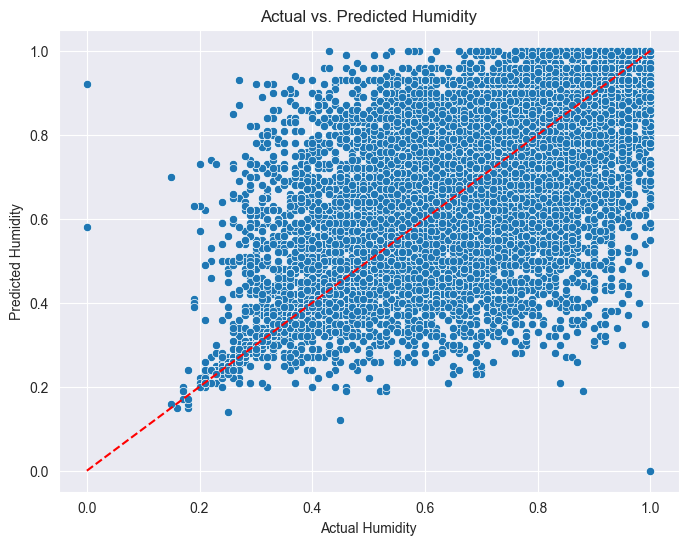

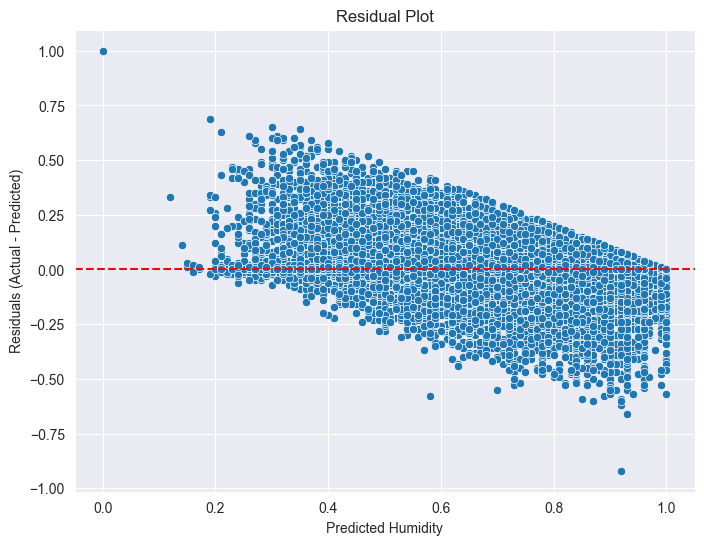

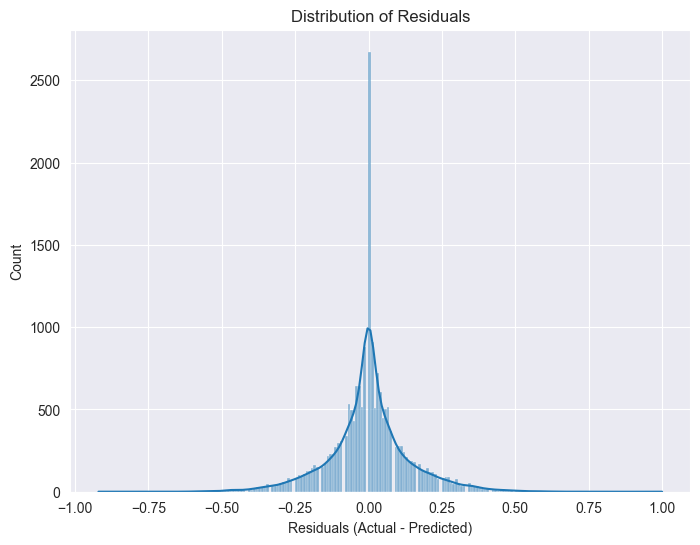

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Scatter Plot of Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Humidity")
plt.ylabel("Predicted Humidity")
plt.title("Actual vs. Predicted Humidity")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') # Add diagonal line
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Humidity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

# 3. Distribution Plot of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Distribution of Residuals")
plt.show()

## **Understanding the Regression Metrics**

1.  **Mean Squared Error (MSE): 0.0194**
    *   The average of the squared differences between predicted and actual humidity values.
    *   The lower the MSE, the better.
    *   **Interpretation:** Because it is squared, it's not in the same units as the humidity, which is between 0 and 1. This makes it hard to interpret what the number really means. We mostly use this for comparing models.
2.  **Root Mean Squared Error (RMSE): 0.1393**
    *   The square root of the MSE. This is in the same units as your target variable (humidity).
    *   **Interpretation:** On average, the model's predictions are about 0.1393 away from the true humidity values. Since humidity is in the range 0 to 1, the model has an average error of 13.93%. This number is easy to interpret since it is in the same scale as your target variable. This is often the most important metric because of this reason.
3.  **Mean Absolute Error (MAE): 0.0948**
    *   The average of the absolute differences between predicted and actual values.
    *   **Interpretation:** On average, the absolute difference between the model's predictions and the true humidity values is about 0.0948, or 9.48%. This is a more robust metric than RMSE since it is less sensitive to outliers. This is also in the same unit as your target variable and easy to interpret.
4.  **R-squared (R2): 0.4908**
    *   Represents the proportion of the variance in the humidity that is predictable by your model.
    *   Ranges from -infinity to 1.
    *   **Interpretation:** The model explains approximately 49.08% of the variability in the humidity data. The rest of the variability is unexplained.

## **Analyzing the Results**

1.  **Error Magnitude:**
    *   An RMSE of 0.1393 (or 13.93% error) and a MAE of 0.0948 (or 9.48% error) means that on average your model's prediction is away from 9.48% to 13.93% from the actual value.
    *   Whether this is considered "good" or "bad" depends entirely on the context of your problem.
        *   If you need very precise humidity predictions, this might be too high.
        *   If you are not very critical about accuracy, this might be fine.
    *   Think about what is the acceptable error for your business requirements. If your requirements are to have errors less than 5%, this result is too high.
2.  **Model Fit:**
    *   An R-squared of 0.4908 means the model explains about 49% of the variance. The R-squared is not too bad, but not very good either.
    *   A low R2 could indicate that the chosen features don't correlate with the target variable well.

3.  **Example Predictions:**
    *   Looking at the first 10 predictions, some predictions are quite accurate (e.g., Predicted: 0.3100, Actual: 0.3100), while others are not (e.g., Predicted: 0.8100, Actual: 0.5900).
    *   The predicted values are generally close to the true values, but it is not always correct.

## **How to Think About Improvements**

1.  **Is the Error Acceptable?**
    *   Start by asking if a RMSE of 13.93% average error is good enough for what you are trying to achieve. If this error is high for what you want to achieve, you have to work on making the model better.

2.  **Feature Engineering:**
    *   Consider if other features (or feature transformations) can help reduce the error. You can try creating time-based features.
3.  **Model Selection:**
    *   If you have issues with this model, it may be beneficial to try other models.
    *   You may have reached the limitation of your model.
    *   Try other models like linear regression, random forest regression, or gradient boosting regression.
4.  **Model Complexity:**
    *   Try different parameters of your current model to improve it.
    *   Use a different `max_depth` for your decision tree.
5.  **Data Preprocessing:**
    *   Check if your data has outliers, missing values, or biases and correct them.

## **Steps to Take Now**

1.  **Review Visualizations:** Look back at the residual plots from previous responses.
    *   Are there patterns in the errors? Is there non-constant variance?
    *   Do the residuals look normally distributed?
2.  **Address Outliers:** If there are outliers, it will reduce the performance of your model. Check if you can remove the outliers from the data or transform the data.
3.  **Experiment with Features:** Try adding and removing features, or applying feature transformation to improve the model's ability to capture patterns in the data.
4.  **Try Different Model:** Consider a different model altogether.

## **In Summary**

Your results indicate that your model has a reasonable level of accuracy with average error of about 10% to 14%. However, there's still room for improvement. You can consider the following steps: feature engineering, model selection, model complexity, data preprocessing. You may want to also look at the residual plots from the previous steps.
